# Processus Gaussien pour prédiction poids

### Librairies

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF

### Données brutes

In [94]:
file_save = os.getcwd() + "/data/dataset.csv"

with open(file_save, 'r') as f:
    df = pd.read_csv(file_save, index_col=0)

In [95]:
df

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR,Calories,Lipides,Glucides,Proteines,exo_duree,exo_cals_bruts,exo_cals_nets,Depense_cal_totale,cal_deficit
2020-08-09,107.250000,37.190000,NaN,NaN,NaN,0.346760,1883.296000,1861.3,71.3,245.0,66.1,0.00,0.0,0.000000,1883.296000,-21.996000
2020-08-11,104.650000,33.150000,NaN,NaN,NaN,0.316770,1914.400000,1772.4,50.5,185.8,104.1,0.00,0.0,0.000000,1914.400000,-142.000000
2020-08-12,104.350000,33.800000,NaN,NaN,NaN,0.323910,1893.880000,1894.3,59.3,220.3,87.5,0.00,0.0,0.000000,1893.880000,0.420000
2020-08-13,104.400000,34.340000,NaN,NaN,NaN,0.328927,1883.296000,1822.6,71.5,227.7,70.2,0.00,0.0,0.000000,1883.296000,-60.696000
2020-08-14,104.500000,33.850000,NaN,NaN,NaN,0.323923,1896.040000,1891.5,61.8,217.2,82.5,0.00,0.0,0.000000,1896.040000,-4.540000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-15,70.258750,11.072500,2.961250,56.208750,39.525000,0.157596,1648.423000,1654.8,45.5,135.1,186.2,3671.21,396.0,325.957095,1974.380095,-319.580095
2023-11-16,70.404286,11.120000,2.967143,56.301429,39.607143,0.157945,1650.540571,1778.7,54.4,128.2,204.9,0.00,0.0,0.000000,1650.540571,128.159429
2023-11-17,70.067500,10.775000,2.968750,56.306250,39.705000,0.153780,1650.718000,1750.0,68.7,96.5,199.2,1134.11,113.0,91.332225,1742.050225,7.949775
2023-11-18,70.686667,10.971111,2.990000,56.710000,40.076667,0.155208,1659.856000,1889.9,67.6,161.3,170.6,5700.00,453.0,343.495611,2003.351611,-113.451611


In [96]:
# clean-up
df1 = df.copy(deep=True)
columns_to_drop = ['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique', 'MG%', 'BMR', 'Lipides', 'Glucides', 'Proteines', 'exo_duree', 'exo_cals_bruts', 'Depense_cal_totale', 'cal_deficit']
df1.drop(columns=columns_to_drop, inplace=True)

In [97]:
df1

,Masse_Totale,Masse_Grasse,Calories,exo_cals_nets
2020-08-09,107.250000,37.190000,1861.3,0.000000
2020-08-11,104.650000,33.150000,1772.4,0.000000
2020-08-12,104.350000,33.800000,1894.3,0.000000
2020-08-13,104.400000,34.340000,1822.6,0.000000
2020-08-14,104.500000,33.850000,1891.5,0.000000
...,...,...,...,...
2023-11-15,70.258750,11.072500,1654.8,325.957095
2023-11-16,70.404286,11.120000,1778.7,0.000000
2023-11-17,70.067500,10.775000,1750.0,91.332225
2023-11-18,70.686667,10.971111,1889.9,343.495611


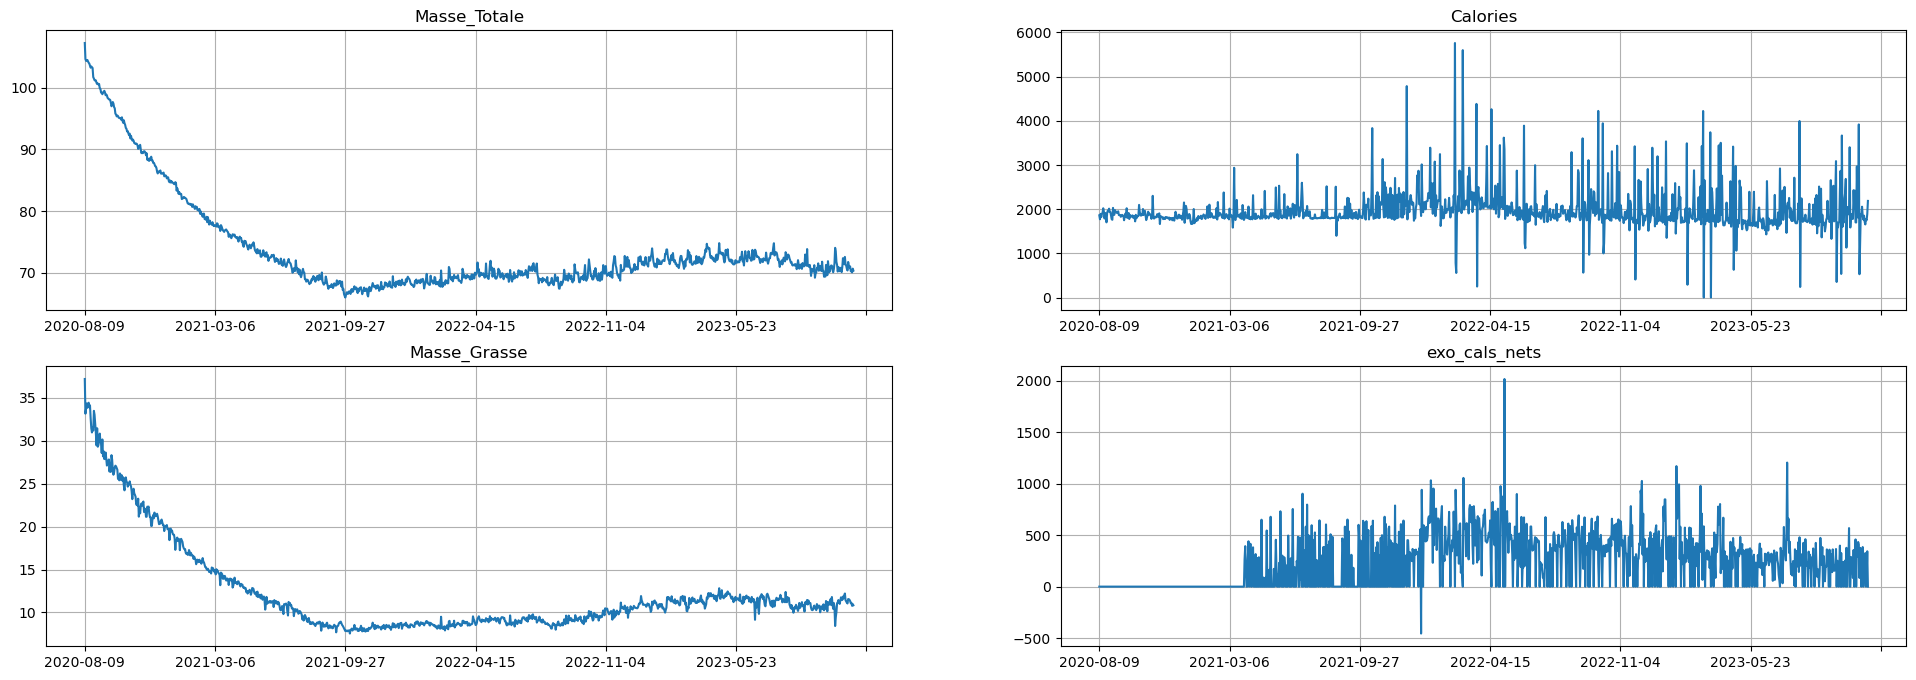

In [98]:
# Visu

fig, axs = plt.subplots(2,2,figsize=(24,8))

for i,name in enumerate(df1.columns):
    r = i%2
    c = i//2
    axs[r,c].set_title(name)
    df1[name].plot(ax=axs[r,c])
    axs[r,c].grid(True)

In [99]:
# need to check that datapoints follow by one day
# and deal with holes

## Création du dataset

### Step 1 : moyennage des données

In [100]:
length_average = 15 # nombre de jours sur lesquels les données de masse totale et masse grasse sont moyennées

In [101]:
def get_df_moyenne(df, length_average=length_average):
    """prend la dataframe et moyenne les valeurs suivant length_average"""
    df = df.rolling(window=length_average).mean()
    df.dropna(inplace=True)
    return df

In [102]:
df2 = get_df_moyenne(df1)

df2

,Masse_Totale,Masse_Grasse,Calories,exo_cals_nets
2020-08-31,103.823333,33.356111,1881.326667,0.000000
2020-09-01,103.421667,33.078111,1891.433333,0.000000
2020-09-02,103.188333,32.997778,1902.606667,0.000000
2020-09-03,102.978333,32.806444,1905.446667,0.000000
2020-09-04,102.738333,32.481111,1907.353333,0.000000
...,...,...,...,...
2023-11-15,71.200835,11.497754,1919.653333,238.882366
2023-11-16,71.219788,11.474420,1924.973333,238.882366
2023-11-17,71.162021,11.429287,1843.760000,221.296973
2023-11-18,71.049608,11.370409,1837.780000,224.792321


### Step 2 : create targets, which are next days's Masse_Totale and Masse_Grasse values

In [103]:
def create_targets(df=df2):
    """créé les targets
    """
    df2 = pd.concat([df.shift(1), df['Masse_Totale'], df['Masse_Grasse']], axis=1)
    df2.columns = ['MT', 'MG', 'Cals', 'Exos', 'MT+1', 'MG+1']
    df2.dropna(inplace=True)
    
    return df2

In [104]:

df2 = create_targets(df2)

df2 

,MT,MG,Cals,Exos,MT+1,MG+1
2020-09-01,103.823333,33.356111,1881.326667,0.000000,103.421667,33.078111
2020-09-02,103.421667,33.078111,1891.433333,0.000000,103.188333,32.997778
2020-09-03,103.188333,32.997778,1902.606667,0.000000,102.978333,32.806444
2020-09-04,102.978333,32.806444,1905.446667,0.000000,102.738333,32.481111
2020-09-05,102.738333,32.481111,1907.353333,0.000000,102.478333,32.321111
...,...,...,...,...,...,...
2023-11-15,71.238474,11.543809,1922.820000,247.741538,71.200835,11.497754
2023-11-16,71.200835,11.497754,1919.653333,238.882366,71.219788,11.474420
2023-11-17,71.219788,11.474420,1924.973333,238.882366,71.162021,11.429287
2023-11-18,71.162021,11.429287,1843.760000,221.296973,71.049608,11.370409


### Step 3 : date de démarrage des données d'entraînement

In [105]:
year = 2020
month = 9
day = 1

In [106]:
from datetime import datetime

def crop_dataset(df=df2, year=year, month=month, day=day):
    """supprime les données avant year,month, date
    """
    df.index = pd.to_datetime(df.index)
    df = df[df.index >= datetime(year=year, month=month, day=day)]
    return df

In [107]:
df2 = crop_dataset().copy(deep=True)

df2

,MT,MG,Cals,Exos,MT+1,MG+1
2020-09-01,103.823333,33.356111,1881.326667,0.000000,103.421667,33.078111
2020-09-02,103.421667,33.078111,1891.433333,0.000000,103.188333,32.997778
2020-09-03,103.188333,32.997778,1902.606667,0.000000,102.978333,32.806444
2020-09-04,102.978333,32.806444,1905.446667,0.000000,102.738333,32.481111
2020-09-05,102.738333,32.481111,1907.353333,0.000000,102.478333,32.321111
...,...,...,...,...,...,...
2023-11-15,71.238474,11.543809,1922.820000,247.741538,71.200835,11.497754
2023-11-16,71.200835,11.497754,1919.653333,238.882366,71.219788,11.474420
2023-11-17,71.219788,11.474420,1924.973333,238.882366,71.162021,11.429287
2023-11-18,71.162021,11.429287,1843.760000,221.296973,71.049608,11.370409


### Step 4 : Construit les train et test sets

In [108]:
# longueur du test set
LAST = 90

In [109]:
def create_train_test_sets(df=df2, last=LAST):
    """create train and test datasets"""
    X = df[['MT', 'MG', 'Cals', 'Exos']]
    y_mt = df['MT+1']
    y_mg = df['MG+1']
    
    X_train = X[:-last]
    X_test = X[-last:]

    y_mt_train = y_mt[:-last]
    y_mt_test = y_mt[-last:]

    y_mg_train = y_mg[:-last]
    y_mg_test = y_mg[-last:]
    
    return X_train, X_test, y_mt_train, y_mt_test, y_mg_train, y_mg_test

In [110]:
X_train, X_test, y_mt_train, y_mt_test, y_mg_train, y_mg_test = create_train_test_sets()

### Instancie un GP par output

In [111]:
# Gaussian process

def get_gpr(length_scale=7, length_scale_bounds=(1e-1, 1e4), noise_level=2.0, noise_level_bounds=(1e-6, 1e2)):
    """Instancie un GPR avec un kernel Gaussien + kernel bruit blanc"""

    kernel = RBF(
        length_scale=length_scale,
        length_scale_bounds=length_scale_bounds
        ) \
        + WhiteKernel(
            noise_level=noise_level,
            noise_level_bounds=noise_level_bounds
            )
    gpr = GaussianProcessRegressor(kernel = kernel, alpha=0.0, random_state=42, normalize_y=True, n_restarts_optimizer=9 )
    
    return gpr, kernel

In [112]:
gpr_mt, kernel_mt = get_gpr()
gpr_mg, kernel_mg = get_gpr()

### Training

In [113]:
gpr_mt.fit(X_train, y_mt_train)

/home/benjamin/anaconda3/envs/toy/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(alpha=0.0,
                         kernel=RBF(length_scale=7) + WhiteKernel(noise_level=2),
                         n_restarts_optimizer=9, normalize_y=True,
                         random_state=42)

In [114]:
gpr_mg.fit(X_train, y_mg_train)

GaussianProcessRegressor(alpha=0.0,
                         kernel=RBF(length_scale=7) + WhiteKernel(noise_level=2),
                         n_restarts_optimizer=9, normalize_y=True,
                         random_state=42)

In [115]:
mean_prediction_mt, std_prediction_mt = gpr_mt.predict(X_train, return_std=True)

In [116]:
mean_prediction_mg, std_prediction_mg = gpr_mg.predict(X_train, return_std=True)

In [117]:
def plot_training(X_train, y_train, y_mean, y_std, gpr, kernel, titre):
    """utility function pour afficher perf sur training set"""
    
    fig, ax = plt.subplots(figsize=(10,6))

    abscisses = np.arange(X_train.shape[0])
    ax.scatter(abscisses, y_train, marker='o', label="Observations", color='blue')
    ax.plot(abscisses, y_mean, marker='.', label="Mean prediction", color='green')
    ax.set_title(
        titre +\
        f" {X_train.shape[0]} points\n" +\
        f"Initial: {kernel}\nOptimum: {gpr.kernel_}\nLog-Marginal-Likelihood: " +\
        f"{gpr.log_marginal_likelihood(gpr.kernel_.theta)}\n" +\
        f"données moyennées sur {length_average} jour(s)"
    )
    ax.grid(True)
    ax.fill_between(
        abscisses,
        y_mean - 1.96 * y_std,
        y_mean + 1.96 * y_std,
        alpha=0.5,
        label=r"95% confidence interval",
    )
    plt.legend()
    
    return fig, ax

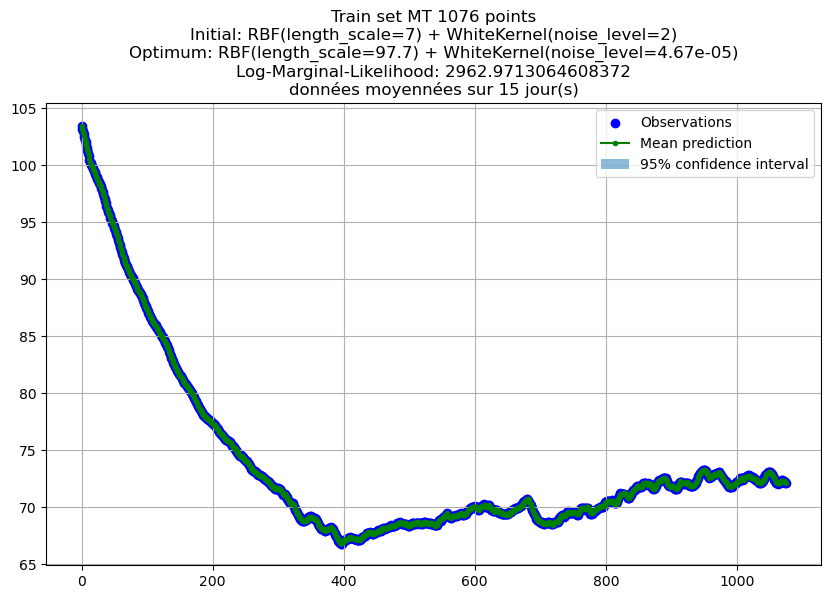

In [118]:
fig, ax = plot_training(X_train, y_mt_train, mean_prediction_mt, std_prediction_mt, gpr_mt, kernel_mt, "Train set MT")

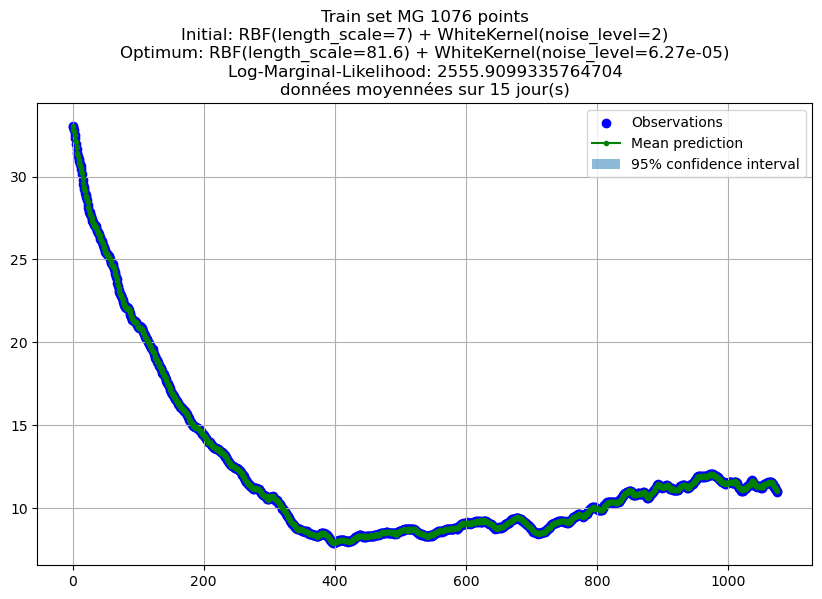

In [119]:
fig, ax = plot_training(X_train, y_mg_train, mean_prediction_mg, std_prediction_mg, gpr_mg, kernel_mg, "Train set MG")

In [120]:
# Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


print(f"Train set : MAE MT = {mean_absolute_error(y_mt_train, mean_prediction_mt)}")
print(f"Train set : MSE MT = {mean_squared_error(y_mt_train, mean_prediction_mt)}")
print(f"Train set : MAE MG = {mean_absolute_error(y_mg_train, mean_prediction_mg)}")
print(f"Train set : MSE MG = {mean_squared_error(y_mg_train, mean_prediction_mg)}")

Train set : MAE MT = 0.038642247435748046
Train set : MSE MT = 0.0024956489973577485
Train set : MAE MG = 0.02781724671503554
Train set : MSE MG = 0.001411285159567838


### Inférences J+1

In [121]:
def plot_inference(X_test, y_test, y_mean, y_std, gpr, kernel, titre):
    """utility function pour afficher perf sur test set avec CI"""
    
    fig, ax = plt.subplots(figsize=(10,6))

    abscisses = np.arange(X_test.shape[0])
    ax.scatter(abscisses, y_test, marker='o', label="Observations", color='blue')
    ax.plot(abscisses, y_mean, marker='.', label="Mean prediction", color='green')
    ax.set_title(
        titre +\
        f" {X_test.shape[0]} points\n" +\
        f"Initial: {kernel}\nOptimum: {gpr.kernel_}\nLog-Marginal-Likelihood: " +\
        f"{gpr.log_marginal_likelihood(gpr.kernel_.theta)}\n" +\
        f"données moyennées sur {length_average} jour(s)"
    )
    ax.grid(True)
    ax.fill_between(
        abscisses,
        y_mean - 1.96 * y_std,
        y_mean + 1.96 * y_std,
        alpha=0.5,
        label=r"95% confidence interval",
    )
    plt.legend()
    
    return fig, ax

In [122]:
mean_prediction_mt, std_prediction_mt = gpr_mt.predict(X_test, return_std=True)

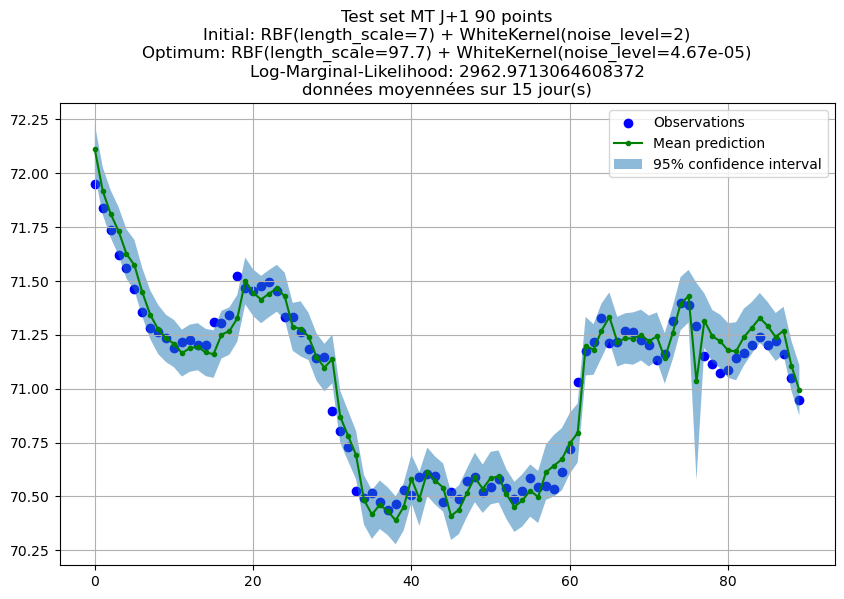

In [123]:
fig, ax = plot_inference(X_test, y_mt_test, mean_prediction_mt, std_prediction_mt, gpr_mt, kernel_mt, "Test set MT J+1")

In [124]:
mean_prediction_mg, std_prediction_mg = gpr_mg.predict(X_test, return_std=True)

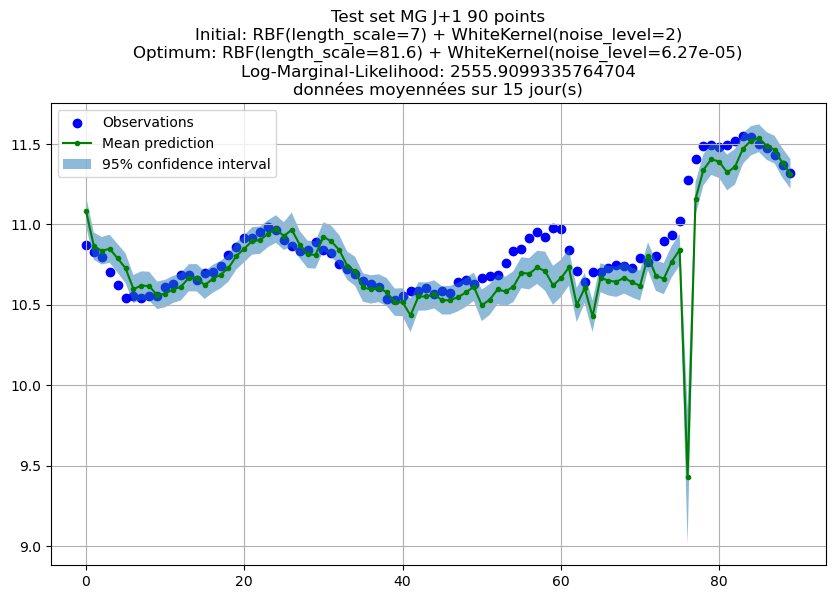

In [125]:
fig, ax = plot_inference(X_test, y_mg_test, mean_prediction_mg, std_prediction_mg, gpr_mg, kernel_mg, "Test set MG J+1")

In [126]:
print(f"Test set J+1 : MAE MT = {mean_absolute_error(y_mt_test, mean_prediction_mt)}")
print(f"Test set J+1 : MSE MT = {mean_squared_error(y_mt_test, mean_prediction_mt)}")
print(f"Test set J+1 : MAE MG = {mean_absolute_error(y_mg_test, mean_prediction_mg)}")
print(f"Test set J+1 : MSE MG = {mean_squared_error(y_mg_test, mean_prediction_mg)}")

Test set J+1 : MAE MT = 0.0650267500023424
Test set J+1 : MSE MT = 0.007151653674527145
Test set J+1 : MAE MG = 0.11168060373357426
Test set J+1 : MSE MG = 0.05211104771923773


### Inférence J+1 à J+N

In [127]:
# horizon de prédiction
horizon = 30

In [128]:
X_test

,MT,MG,Cals,Exos
2023-08-22,72.078395,10.997971,1737.546667,221.401689
2023-08-23,71.949679,10.868655,1834.053333,228.571227
2023-08-24,71.838484,10.828164,1821.600000,225.009239
2023-08-25,71.734189,10.793288,1786.686667,204.086501
2023-08-26,71.620771,10.704399,1775.713333,209.155740
...,...,...,...,...
2023-11-15,71.238474,11.543809,1922.820000,247.741538
2023-11-16,71.200835,11.497754,1919.653333,238.882366
2023-11-17,71.219788,11.474420,1924.973333,238.882366
2023-11-18,71.162021,11.429287,1843.760000,221.296973


In [129]:
X_test_pred = X_test[:horizon].copy(deep=True)

In [130]:
def inference_horizon(X_test_pred=X_test_pred, gpr_mt=gpr_mt, gpr_mg=gpr_mg):
    """inférence sur plusieurs jours"""
    
    y_pred_mt = []  # prédiction MT
    y_pred_mg = []  # prédiction MG
    y_pred_mt_std = []  # écart-type prédiction MT
    y_pred_mg_std = []  # écart-type prédiction MG

    # initialisation des valeurs de départ
    next_mt = X_test_pred.iloc[0,0]
    next_mg = X_test_pred.iloc[0,1]
    
    for r in range(len(X_test_pred)):
        # on extrait les inputs du jour et on remplace les valeurs MT, MG du jour par celles prédites
        row = X_test_pred.iloc[r:r+1,:].copy(deep=True)
        mini_X_test = pd.DataFrame(
            data = { 'MT' : next_mt,
                    'MG' : next_mg,
                    'Cals' : row['Cals'],
                    'Exos' : row['Exos']}
        )
        # on prédit MT à J+1
        pred_mt, pred_mt_std = gpr_mt.predict(mini_X_test, return_std=True)
        next_mt = pred_mt[0]
        y_pred_mt.append(next_mt)
        y_pred_mt_std.append(pred_mt_std[0])
        # on prédit MG à J+1
        pred_mg, pred_mg_std = gpr_mg.predict(mini_X_test, return_std=True)
        next_mg = pred_mg[0]
        y_pred_mg.append(next_mg)
        y_pred_mg_std.append(pred_mg_std[0])
        
    y_pred_mt_std = np.array(y_pred_mt_std)
    y_pred_mg_std = np.array(y_pred_mg_std)
        
    return y_pred_mt, y_pred_mg, y_pred_mt_std, y_pred_mg_std

In [131]:
y_pred_mt, y_pred_mg, y_pred_mt_std, y_pred_mg_std = inference_horizon(gpr_mt=gpr_mt, gpr_mg=gpr_mg)

In [132]:
def plot_inference_horizon(X_test, y_test, y_mean, y_std, gpr, kernel, titre):
    """utility function pour afficher perf sur test set avec CI"""
    
    fig, ax = plt.subplots(figsize=(10,6))

    abscisses = np.arange(X_test.shape[0])
    ax.scatter(abscisses, y_test[:horizon], marker='o', label="Observations", color='blue')
    ax.plot(abscisses, y_mean, marker='.', label="Mean prediction", color='green')
    ax.set_title(f"Test set {X_test.shape[0]} points. Inférence J+2 avec valeur prédite à J+1\n" f"Initial: {kernel}\nOptimum: {gpr.kernel_}\nLog-Marginal-Likelihood: "
        f"{gpr_mt.log_marginal_likelihood(gpr.kernel_.theta)}\n" \
            f"données moyennées sur {length_average} jours" 
    )
    ax.grid(True)
    ax.fill_between(
        abscisses,
        y_mean - 1.96 * y_std,
        y_mean + 1.96 * y_std,
        alpha=0.5,
        label=r"95% confidence interval",
    )
    plt.legend()
    
    return fig, ax

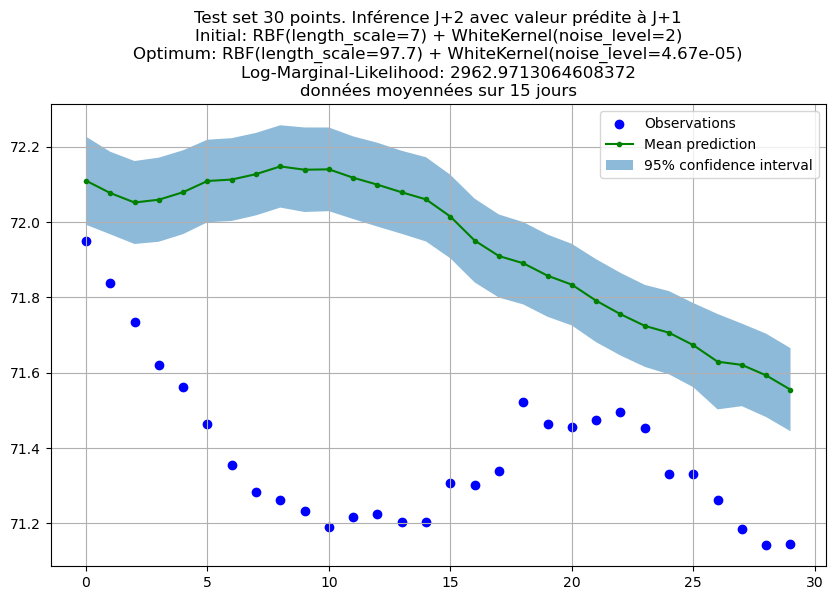

In [133]:
fig, ax = plot_inference_horizon(X_test_pred, y_mt_test, y_pred_mt, y_pred_mt_std, gpr_mt, kernel_mt, "Prediction longue MT")

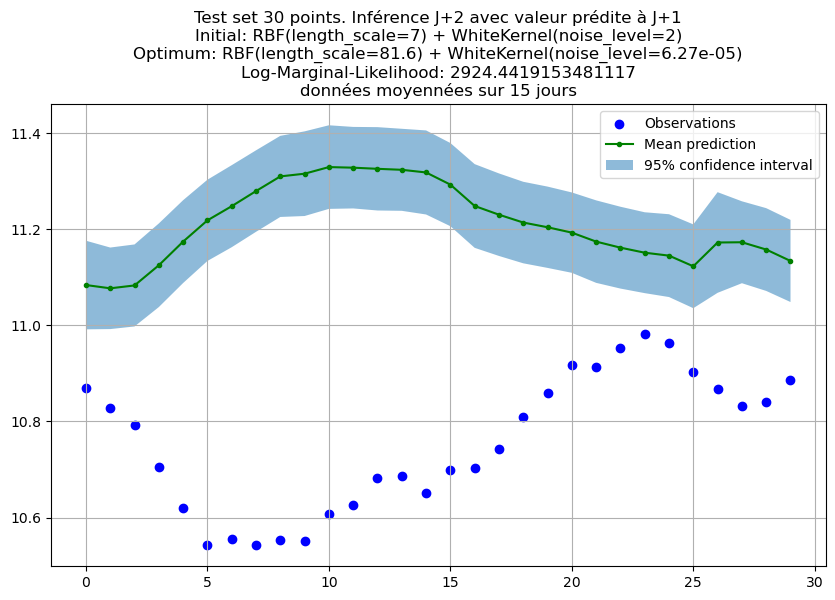

In [134]:
fig, ax = plot_inference_horizon(X_test_pred, y_mg_test, y_pred_mg, y_pred_mg_std, gpr_mg, kernel_mg, "Prediction longue MG")

In [135]:
print(f"Test set J+{horizon} : MAE MT = {mean_absolute_error(y_mt_test[:horizon], y_pred_mt)}")
print(f"Test set J+{horizon} : MSE MT = {mean_squared_error(y_mt_test[:horizon], y_pred_mt)}")
print(f"Test set J+{horizon} : MAE MG = {mean_absolute_error(y_mg_test[:horizon], y_pred_mg)}")
print(f"Test set J+{horizon} : MSE MG = {mean_squared_error(y_mg_test[:horizon], y_pred_mg)}")

Test set J+30 : MAE MT = 0.5486033308072616
Test set J+30 : MSE MT = 0.3600228783792645
Test set J+30 : MAE MG = 0.45442973545353826
Test set J+30 : MSE MG = 0.2477500958858442


## Grid Search

In [44]:
# hyperparamètres

length_average_list = [1, 3, 7, 15] # durée moyennage des données
start_date_list = [ (2020, 9, 1), (2021, 6, 1) ] #, (2021, 6, 1)]  # démarrage des données
horizon_list = [3, 7, 15, 30]  # horizons de prédiction

In [45]:
import itertools

In [46]:
resultats_totaux = {}
i = 1

for length_average, start_date, horizon in itertools.product(length_average_list, start_date_list, horizon_list):
    
    print(f"\nModèle : données moyennées sur {length_average} jours, date départ = {start_date}, horizon de prédiction = {horizon} jours")
    resultats_run = {}
    year, month, day = start_date
    
    resultats_run["duree_moyennage"] = length_average
    resultats_run["date_demarrage"] = start_date
    resultats_run["horizon_prediction"] = horizon
    
    # create dataset
    print(f"... create dataset")
    df2 = get_df_moyenne(df1, length_average=length_average)  # moyenne les données
    df2 = create_targets(df=df2) # retire les données non-utilisées
    df2 = crop_dataset(df=df2, year=year, month=month, day=day).copy(deep=True)
    df2
    X_train, X_test, y_mt_train, y_mt_test, y_mg_train, y_mg_test = create_train_test_sets(df=df2)
    
    # create and train models
    print(f"... train MT model")
    gpr_mt, kernel_mt = get_gpr()
    gpr_mt.fit(X_train, y_mt_train)
    
    print(f"... train MG model")
    gpr_mg, kernel_mg = get_gpr()  
    gpr_mg.fit(X_train, y_mg_train)
    
    # performance metrics sur training set
    print(f"... calculate performance on train set {len(X_train)} points")
    mean_prediction_mt, std_prediction_mt = gpr_mt.predict(X_train, return_std=True)
    mean_prediction_mg, std_prediction_mg = gpr_mg.predict(X_train, return_std=True) 
    
    lml = gpr_mt.log_marginal_likelihood(gpr_mt.kernel_.theta)
    print(f"Log marginal likelihood MT : {lml}")
    resultats_run["Log_marginal_likelihood_MT"] = lml
    
    lml = gpr_mg.log_marginal_likelihood(gpr_mg.kernel_.theta)
    print(f"Log marginal likelihood MG : {gpr_mg.log_marginal_likelihood(gpr_mg.kernel_.theta)}")
    resultats_run["Log_marginal_likelihood_MG"] = lml
    
    erreur = mean_absolute_error(y_mt_train, mean_prediction_mt)
    print(f"Train set : MAE MT = {erreur}")
    resultats_run["Train_set_MAE_MT"] = erreur
    
    erreur = mean_squared_error(y_mt_train, mean_prediction_mt)
    print(f"Train set : MSE MT = {erreur}")
    resultats_run["Train_set_MSE_MT"] = erreur
    
    erreur = mean_absolute_error(y_mg_train, mean_prediction_mg)
    print(f"Train set : MAE MG = {erreur}")
    resultats_run["Train_set_MAE_MG"] = erreur
    
    erreur = mean_squared_error(y_mg_train, mean_prediction_mg)
    print(f"Train set : MSE MG = {erreur}")
    resultats_run["Train_set_MSE_MG"] = erreur
    
    # inférence J+1, performance
    print(f"... calculate J+1 prediction performance on test set {len(X_test)} points")
    
    mean_prediction_mt, std_prediction_mt = gpr_mt.predict(X_test, return_std=True)
    mean_prediction_mg, std_prediction_mg = gpr_mg.predict(X_test, return_std=True)
    
    erreur = mean_absolute_error(y_mt_test, mean_prediction_mt)
    print(f"Test set J+1: MAE MT = {erreur}")
    resultats_run["Test_set_MAE_MT_J_1"] = erreur
    
    erreur = mean_squared_error(y_mt_test, mean_prediction_mt)
    print(f"Test set J+1 : MSE MT = {erreur}")
    resultats_run["Test_set_MSE_MT_J_1"] = erreur
    
    erreur = mean_absolute_error(y_mg_test, mean_prediction_mg)
    print(f"Test set J+1: MAE MG = {erreur}")
    resultats_run["Test_set_MAE_MG_J_1"] = erreur
    
    erreur = mean_squared_error(y_mg_test, mean_prediction_mg)
    print(f"Test set J+1: MSE MG = {erreur}")
    resultats_run["Test_set_MSE_MG_J_1"] = erreur
    
    # inférence J+horizon, performance
    print(f"... calculate J+{horizon} prediction performance on test set {len(X_test[:horizon])} points")
        
    X_test_pred = X_test[:horizon].copy(deep=True)
    y_pred_mt, y_pred_mg, y_pred_mt_std, y_pred_mg_std = inference_horizon(X_test_pred=X_test_pred, gpr_mt=gpr_mt, gpr_mg=gpr_mg)
        
        # lml = gpr_mt.log_marginal_likelihood(gpr_mt.kernel_.theta)
        # print(f"Log marginal likelihood MT : {lml}")
        # resultats_run["Log_marginal_likelihood_MT_J_horizon"] = lml
        
        # lml = gpr_mg.log_marginal_likelihood(gpr_mg.kernel_.theta)
        # print(f"Log marginal likelihood MG : {gpr_mg.log_marginal_likelihood(gpr_mg.kernel_.theta)}")
        # resultats_run["Log_marginal_likelihood_MG_J_horizon"] = lml
        
    erreur = mean_absolute_error(y_mt_test[:horizon], y_pred_mt)
    print(f"Test set J+{horizon}: MAE MT = {erreur}")
    resultats_run["Test_set_MAE_MT_J_horizon"] = erreur
        
    erreur = mean_squared_error(y_mt_test[:horizon], y_pred_mt)
    print(f"Test set J+{horizon} : MSE MT = {erreur}")
    resultats_run["Test_set_MSE_MT_J_horizon"] = erreur
        
    erreur = mean_absolute_error(y_mg_test[:horizon], y_pred_mg)
    print(f"Test set J+{horizon}: MAE MG = {erreur}")
    resultats_run["Test_set_MAE_MG_J_horizon"] = erreur
        
    erreur = mean_squared_error(y_mg_test[:horizon], y_pred_mg)
    print(f"Test set J+{horizon}: MSE MG = {erreur}")
    resultats_run["Test_set_MSE_MG_J_horizon"] = erreur
    
    # log les résultats
    resultats_totaux[i] = resultats_run
    i += 1
    
    print(f"\n")

    


Modèle : données moyennées sur 1 jours, date départ = (2020, 9, 1), horizon de prédiction = 3 jours
... create dataset
... train MT model
... train MG model
... calculate performance on train set 1076 points
Log marginal likelihood MT : 370.1267828385936
Log marginal likelihood MG : 186.9088820038795
Train set : MAE MT = 0.3293779865853289
Train set : MSE MT = 0.1994138681036114
Train set : MAE MG = 0.31390160296849057
Train set : MSE MG = 0.1817116795754659
... calculate J+1 prediction performance on test set 90 points
Test set J+1: MAE MT = 1.0109836857727144
Test set J+1 : MSE MT = 1.8654285234396093
Test set J+1: MAE MG = 0.7068071077880257
Test set J+1: MSE MG = 0.8635089630510797
... calculate J+3 prediction performance on test set 3 points
Test set J+3: MAE MT = 0.5804991748936601
Test set J+3 : MSE MT = 0.4790982997901583
Test set J+3: MAE MG = 0.2573147736426146
Test set J+3: MSE MG = 0.07120770079276002



Modèle : données moyennées sur 1 jours, date départ = (2020, 9, 1), h

/home/benjamin/anaconda3/envs/toy/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


... train MG model
... calculate performance on train set 1076 points
Log marginal likelihood MT : 2962.9713064608372
Log marginal likelihood MG : 2555.9099335764704
Train set : MAE MT = 0.038642247435748046
Train set : MSE MT = 0.0024956489973577485
Train set : MAE MG = 0.02781724671503554
Train set : MSE MG = 0.001411285159567838
... calculate J+1 prediction performance on test set 90 points
Test set J+1: MAE MT = 0.0650267500023424
Test set J+1 : MSE MT = 0.007151653674527145
Test set J+1: MAE MG = 0.11168060373357426
Test set J+1: MSE MG = 0.05211104771923773
... calculate J+3 prediction performance on test set 3 points
Test set J+3: MAE MT = 0.23836934886592095
Test set J+3 : MSE MT = 0.060956359330778455
Test set J+3: MAE MG = 0.2513271643990003
Test set J+3: MSE MG = 0.0640933636117747



Modèle : données moyennées sur 15 jours, date départ = (2020, 9, 1), horizon de prédiction = 7 jours
... create dataset
... train MT model


/home/benjamin/anaconda3/envs/toy/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


... train MG model
... calculate performance on train set 1076 points
Log marginal likelihood MT : 2962.9713064608372
Log marginal likelihood MG : 2555.9099335764704
Train set : MAE MT = 0.038642247435748046
Train set : MSE MT = 0.0024956489973577485
Train set : MAE MG = 0.02781724671503554
Train set : MSE MG = 0.001411285159567838
... calculate J+1 prediction performance on test set 90 points
Test set J+1: MAE MT = 0.0650267500023424
Test set J+1 : MSE MT = 0.007151653674527145
Test set J+1: MAE MG = 0.11168060373357426
Test set J+1: MSE MG = 0.05211104771923773
... calculate J+7 prediction performance on test set 7 points
Test set J+7: MAE MT = 0.43937276501214384
Test set J+7 : MSE MT = 0.23364331251103357
Test set J+7: MAE MG = 0.4425877670272233
Test set J+7: MSE MG = 0.2305666085689119



Modèle : données moyennées sur 15 jours, date départ = (2020, 9, 1), horizon de prédiction = 15 jours
... create dataset
... train MT model


/home/benjamin/anaconda3/envs/toy/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


... train MG model
... calculate performance on train set 1076 points
Log marginal likelihood MT : 2962.9713064608372
Log marginal likelihood MG : 2555.9099335764704
Train set : MAE MT = 0.038642247435748046
Train set : MSE MT = 0.0024956489973577485
Train set : MAE MG = 0.02781724671503554
Train set : MSE MG = 0.001411285159567838
... calculate J+1 prediction performance on test set 90 points
Test set J+1: MAE MT = 0.0650267500023424
Test set J+1 : MSE MT = 0.007151653674527145
Test set J+1: MAE MG = 0.11168060373357426
Test set J+1: MSE MG = 0.05211104771923773
... calculate J+15 prediction performance on test set 15 points
Test set J+15: MAE MT = 0.6778105151194249
Test set J+15 : MSE MT = 0.5286169986160215
Test set J+15: MAE MG = 0.5818063413905342
Test set J+15: MSE MG = 0.37279949984416116



Modèle : données moyennées sur 15 jours, date départ = (2020, 9, 1), horizon de prédiction = 30 jours
... create dataset
... train MT model


/home/benjamin/anaconda3/envs/toy/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


... train MG model
... calculate performance on train set 1076 points
Log marginal likelihood MT : 2962.9713064608372
Log marginal likelihood MG : 2555.9099335764704
Train set : MAE MT = 0.038642247435748046
Train set : MSE MT = 0.0024956489973577485
Train set : MAE MG = 0.02781724671503554
Train set : MSE MG = 0.001411285159567838
... calculate J+1 prediction performance on test set 90 points
Test set J+1: MAE MT = 0.0650267500023424
Test set J+1 : MSE MT = 0.007151653674527145
Test set J+1: MAE MG = 0.11168060373357426
Test set J+1: MSE MG = 0.05211104771923773
... calculate J+30 prediction performance on test set 30 points
Test set J+30: MAE MT = 0.5486033308072616
Test set J+30 : MSE MT = 0.3600228783792645
Test set J+30: MAE MG = 0.45442973545353826
Test set J+30: MSE MG = 0.2477500958858442



Modèle : données moyennées sur 15 jours, date départ = (2021, 6, 1), horizon de prédiction = 3 jours
... create dataset
... train MT model
... train MG model
... calculate performance on tr

In [47]:
resultats_totaux

{1: {'duree_moyennage': 1,
  'date_demarrage': (2020, 9, 1),
  'horizon_prediction': 3,
  'Log_marginal_likelihood_MT': 370.1267828385936,
  'Log_marginal_likelihood_MG': 186.9088820038795,
  'Train_set_MAE_MT': 0.3293779865853289,
  'Train_set_MSE_MT': 0.1994138681036114,
  'Train_set_MAE_MG': 0.31390160296849057,
  'Train_set_MSE_MG': 0.1817116795754659,
  'Test_set_MAE_MT_J_1': 1.0109836857727144,
  'Test_set_MSE_MT_J_1': 1.8654285234396093,
  'Test_set_MAE_MG_J_1': 0.7068071077880257,
  'Test_set_MSE_MG_J_1': 0.8635089630510797,
  'Test_set_MAE_MT_J_horizon': 0.5804991748936601,
  'Test_set_MSE_MT_J_horizon': 0.4790982997901583,
  'Test_set_MAE_MG_J_horizon': 0.2573147736426146,
  'Test_set_MSE_MG_J_horizon': 0.07120770079276002},
 2: {'duree_moyennage': 1,
  'date_demarrage': (2020, 9, 1),
  'horizon_prediction': 7,
  'Log_marginal_likelihood_MT': 370.1267828385936,
  'Log_marginal_likelihood_MG': 186.9088820038795,
  'Train_set_MAE_MT': 0.3293779865853289,
  'Train_set_MSE_MT': 0

In [48]:
import json

file_save = os.getcwd() + "/data/resultats.json"

with open(file_save, 'w') as f:
    json.dump(resultats_totaux, f)

In [49]:
print(json.dumps(resultats_totaux, sort_keys=False, indent=4))

{
    "1": {
        "duree_moyennage": 1,
        "date_demarrage": [
            2020,
            9,
            1
        ],
        "horizon_prediction": 3,
        "Log_marginal_likelihood_MT": 370.1267828385936,
        "Log_marginal_likelihood_MG": 186.9088820038795,
        "Train_set_MAE_MT": 0.3293779865853289,
        "Train_set_MSE_MT": 0.1994138681036114,
        "Train_set_MAE_MG": 0.31390160296849057,
        "Train_set_MSE_MG": 0.1817116795754659,
        "Test_set_MAE_MT_J_1": 1.0109836857727144,
        "Test_set_MSE_MT_J_1": 1.8654285234396093,
        "Test_set_MAE_MG_J_1": 0.7068071077880257,
        "Test_set_MSE_MG_J_1": 0.8635089630510797,
        "Test_set_MAE_MT_J_horizon": 0.5804991748936601,
        "Test_set_MSE_MT_J_horizon": 0.4790982997901583,
        "Test_set_MAE_MG_J_horizon": 0.2573147736426146,
        "Test_set_MSE_MG_J_horizon": 0.07120770079276002
    },
    "2": {
        "duree_moyennage": 1,
        "date_demarrage": [
            2020,
     